# Random Forest

Some brief notes about decision trees and random forest mathods, taken from Nando de Freitas
' lecture: https://www.youtube.com/watch?v=-dCtJjlEEgM

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import math
plt.rc('font', size=20)          # controls default text sizes
plt.rc('axes', titlesize=16)     # fontsize of the axes title
plt.rc('axes', labelsize=16)    # fontsize of the x and y labels   # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels

## 1. Constructing decision trees

### How do you decide which attributes (features) to use to split the data at each node?

The first thing to note is that we use a **greedy** algorithm to construct the tree. That is, at each node, we pick the optimal feature to make the split. This may not be the way to construct the optimal tree, but enumerating all possible trees is often computationally infeasible so the greedy algorithm is used as an efficient heuristic. Due to using the greedy algorithm, trees have **high variance**: if we change the label on one single training datum, we might end up with a very different tree structure. Random forest corrects for this variance by averaging lots of trees together. 
<br><br>
So how do you choose the feature to split on?
- Intuitively, you want to choose the feature that *tells you the most* about the data labels.
- A good choice of feature will *ideally* split the data into subsets that are all positive or all negative.

Consider the distribution of the data at the root node. At the root node you're working with the entire training set, and you have some probability distribution over the labels (+1, -1). If the data is balanced, then each point at the root node has a 50% chance of being +1 and a 50% chance of being -1.
<br><br>
You want to split the data in a way that shifts the probability histogram towards one of the labels. As a counter example, assume you split on some feature such that the subsets at each child node are still 50% +1 and 50% -1. You've learned nothing about your data by making this split - it is useless. You'd rather want to perform a split such that the histograms at each child node begin to concentrate about one label.

### Entropy

In order to decide which feature to use to split the data, we'll use the concept of entropy. Entropy is a measure of uncertainty, or equivalently, a measure of information. The units of entropy are *bits*.

Formally, for $n$ classes with marginal probabilities $p_{n}$:

$$
H = \sum^{n}_{i=1} - p_{n}log(p_{n})
$$

For binary classification:

$$
H\big( \ p^{+} \ , p^{-} \ \big) = - p^{+} log_{2} \big( p^{+} \big) - p^{-} log_{2} \big( p^{-} \big)
$$


Or, for a training set with $p$ positive examples and $n$ negative examples:

$$
H\Big( \frac{p}{p+n} \ , \frac{n}{p+n} \Big) = - \frac{p}{p+n} log_{2} \Big( \frac{p}{p+n} \Big) - \frac{n}{p+n} log_{2} \Big( \frac{n}{p+n} \Big)
$$

a plot of entropy as a function of $p^{+}$ is shown below:

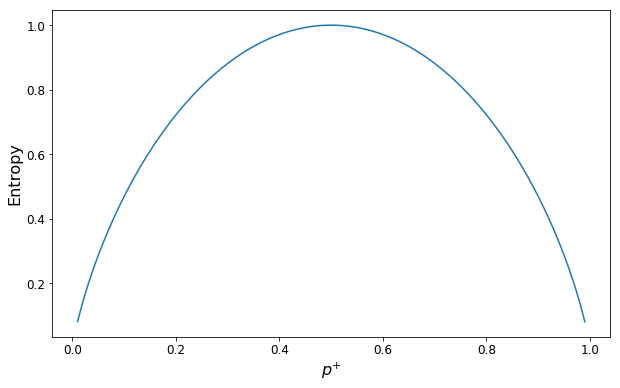

In [42]:
def H(fp):
    fn = 1.0 - fp
    H = -1.0 * fp * math.log(fp,2) - fn * math.log(fn,2)
    return H

fp_ = np.arange(0.01,1,0.01)
H_ = [ H(fp) for fp in fp_ ]
plt.figure(figsize=(10,6))
plt.plot(fp_, H_)
plt.xlabel('$p^{+}$')
plt.ylabel('Entropy')
plt.show()

As we can see **entropy is maximized when the distribution of labels is uniform**, or when there are equal numbers of positive and negative data points at a node.

#### So how do we use entropy to split at each node?

Say we choose to split on attribute $A$, which takes $k$ different values, and splits the training set $E$ into subsets $\{E_{1}, \ ..., \ E_{k}\}$. We define the **expected entropy (EH)** remaining after splitting on attribute $A$ to be:

$$
EH(A) = \sum^{k}_{i=1} \frac {p_i+p_n} {p + n} H\Big( \frac{p_i}{p_i+n_i} \ , \frac{n_i}{p_i+n_i} \Big)
$$

Notice that **this is an expectation: a weighted average of the entropies of the child nodes**.
<br><br>
We then define the **information gain** of attribute $A$ as **the reduction of entropy that would result from splitting the data using attribute A**:

$$
I(A) = H\Big( \frac{p}{p+n} \ , \frac{n}{p+n} \Big) - EH(A)
$$

So we want to choose the attribute $A$ that gives us the maximum information gain. To construct the tree repeat this process recursively for subsequent nodes until we've split the data cleanly.

### How do we deal with continuous-valued features?

One way to create attributes from a continuous valued feature is to use thresholds. This basically turns a continuous variable into a binary variable representing if it is above or below the chosed threshold.
<br><br>
Assume we have 2-dimensional continuous data (x,y). One way to create attributes from this data is to create equally-spaced grid on the X and Y axes, where each gridline is a threshold value. Assume you split the X axis using 10 thresholds and you split the Y axis using 10 thresholds. Then each 2D data point (x,y) gets converted to a 20-dimensional binary vector where each entry represents if the datum is above or below a given threshold on the x or y axes.
<br><br>
For deeper reading and some examples of this procedure, see the Microsoft Research technical report **Decision Forests for Classification,Regression, Density Estimation, Manifold Learning and Semi-Supervised Learning**: 
https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/decisionForests_MSR_TR_2011_114.pdf
<br><br>
Rather than exhaustively gridding each dimension for all possible splits, you can also choose splits randomly and still get pretty good results. Also, for very high dimensional data, before choosing the splits you can sample a subset of the dimensions to evaluate your splits on, to make things even faster.